In [1]:
# load library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [2]:
# load data
r2d0 = pd.read_csv('island-data-bottle-round-2/prices_round_2_day_-1.csv', sep = ';')
r2d1 = pd.read_csv('island-data-bottle-round-2/prices_round_2_day_0.csv', sep = ';')
r2d2 = pd.read_csv('island-data-bottle-round-2/prices_round_2_day_1.csv', sep = ';')
def update_timestamp(df):
    df['timestamp'] = df['day']*100*10000+df['timestamp']
    df.drop(['day'], axis = 1, inplace = True)
    return df

r2d0_shift = update_timestamp(r2d0)
r2d1_shift = update_timestamp(r2d1)
r2d2_shift = update_timestamp(r2d2)

# merge the three dataframes into one
r2 = pd.concat([r2d0_shift, r2d1_shift, r2d2_shift], axis = 0)

In [3]:
r2.head(4)

,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-1000000,PEARLS,10002,1,9996.0,2.0,9995.0,29.0,10004,2,10005.0,29.0,NaN,NaN,10003.0,0.0
1,-1000000,PINA_COLADAS,14999,38,14998.0,53.0,NaN,NaN,15001,38,15002.0,53.0,NaN,NaN,15000.0,0.0
2,-1000000,COCONUTS,7999,162,NaN,NaN,NaN,NaN,8001,55,8002.0,107.0,NaN,NaN,8000.0,0.0
3,-1000000,BANANAS,4951,1,4946.0,2.0,4945.0,29.0,4952,31,NaN,NaN,NaN,NaN,4951.5,0.0


In [4]:
def plot_orderbook_dist(df,ticker = 'BANANAS'):
    
    df[df['product']==ticker]['bid_volume_1'].hist(bins=100)
    df[df['product']==ticker]['ask_volume_1'].hist(bins=100)
    plt.title(ticker+' orderbook best bid and ask volume distribution')
    plt.legend(['bid_volume_1','ask_volume_1'])
    plt.show()
    plt.plot(df[df['product']==ticker]['bid_volume_1'],df[df['product']==ticker]['ask_volume_1'],'.')
    plt.title(ticker+' orderbook best bid and ask volume scatter')
    plt.xlabel('bid_volume_1')
    plt.ylabel('ask_volume_1')
    plt.show()

def calculate_volume_imbalance(df,level = 1):

    df['volume_imbalance_'+str(level)] = np.arctan((df['bid_volume_'+str(level)] - df['ask_volume_'+str(level)])/(df['bid_volume_'+str(level)] + df['ask_volume_'+str(level)]))*4/np.pi
    # df['volume_imbalance_'+str(level)].fillna(0,inplace=True)
    return df.copy()

def cal_orderbook_imbalance_status(df):
    df['imbalance_status'] = 0
    # for pearls and bananas, we use a threshold of 15 for the bid and ask volume to encode the imbalance status
    # for coconut, we use a threshold of 50 for hte bid and ask volume to encode the imbalance status
    # for pina colada, we use a threshold of 100 for the bid and ask volume to encode the imbalance status
    df.loc[(df['bid_volume_1']>15) & (df['ask_volume_1']>15) & (df['product']=='BANANAS'),'imbalance_status'] = 10 # high liquidity on both sides
    df.loc[(df['bid_volume_1']<=15) & (df['ask_volume_1']>15) & (df['product']=='BANANAS'),'imbalance_status'] = -1 # low liquidity on the bid side, tend to have a negative price movement
    df.loc[(df['bid_volume_1']>15) & (df['ask_volume_1']<=15) & (df['product']=='BANANAS'),'imbalance_status'] = 1 # low liquidity on the ask side, tend to have a positive price movement
    df.loc[(df['bid_volume_1']<=15) & (df['ask_volume_1']<=15) & (df['product']=='BANANAS'),'imbalance_status'] = 0 # low liquidity on both sides

    df.loc[(df['bid_volume_1']>15) & (df['ask_volume_1']>15) & (df['product']=='PEARLS'),'imbalance_status'] = 10
    df.loc[(df['bid_volume_1']<=15) & (df['ask_volume_1']>15) & (df['product']=='PEARLS'),'imbalance_status'] = -1
    df.loc[(df['bid_volume_1']>15) & (df['ask_volume_1']<=15) & (df['product']=='PEARLS'),'imbalance_status'] = 1
    df.loc[(df['bid_volume_1']<=15) & (df['ask_volume_1']<=15) & (df['product']=='PEARLS'),'imbalance_status'] = 0

    df.loc[(df['bid_volume_1']>50) & (df['ask_volume_1']>50) & (df['product']=='COCONUTS'),'imbalance_status'] = 10
    df.loc[(df['bid_volume_1']<=50) & (df['ask_volume_1']>50) & (df['product']=='COCONUTS'),'imbalance_status'] = -1
    df.loc[(df['bid_volume_1']>50) & (df['ask_volume_1']<=50) & (df['product']=='COCONUTS'),'imbalance_status'] = 1
    df.loc[(df['bid_volume_1']<=50) & (df['ask_volume_1']<=50) & (df['product']=='COCONUTS'),'imbalance_status'] = 0

    df.loc[(df['bid_volume_1']>100) & (df['ask_volume_1']>100) & (df['product']=='PINA_COLADAS'),'imbalance_status'] = 10
    df.loc[(df['bid_volume_1']<=100) & (df['ask_volume_1']>100) & (df['product']=='PINA_COLADAS'),'imbalance_status'] = -1
    df.loc[(df['bid_volume_1']>100) & (df['ask_volume_1']<=100) & (df['product']=='PINA_COLADAS'),'imbalance_status'] = 1
    df.loc[(df['bid_volume_1']<=100) & (df['ask_volume_1']<=100) & (df['product']=='PINA_COLADAS'),'imbalance_status'] = 0
    # for VIRTUAL_ETF, we use a threshold of 40 for the bid and ask volume to encode the imbalance status
    df.loc[(df['bid_volume_1']>40) & (df['ask_volume_1']>40) & (df['product']=='VIRTUAL_ETF'),'imbalance_status'] = 10
    df.loc[(df['bid_volume_1']<=40) & (df['ask_volume_1']>40) & (df['product']=='VIRTUAL_ETF'),'imbalance_status'] = -1
    df.loc[(df['bid_volume_1']>40) & (df['ask_volume_1']<=40) & (df['product']=='VIRTUAL_ETF'),'imbalance_status'] = 1
    df.loc[(df['bid_volume_1']<=40) & (df['ask_volume_1']<=40) & (df['product']=='VIRTUAL_ETF'),'imbalance_status'] = 0
    
    return df.copy()

def calculate_future_mid_price_movement(df, window_size = 9):
    for ticker in df['product'].unique():
        for i in range(window_size+1):
            df.loc[df['product'] == ticker, 'future_mid_price_move_'+str(i)] = df[df['product'] == ticker]['mid_price'].diff(i).shift(-i)

    return df.copy()

def plot_em_am(df,ticker,signal):
    temp = df[df['product'] == ticker]
    fig, axs = plt.subplots(3, 3, figsize=(20, 10), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()
    for i in range(9):
        axs[i].plot(temp[signal],temp['future_mid_price_move_'+str(i+1)],'o')
        axs[i].set_title("Correlation between future_mid_price_move_"+str(i+1)+"\n and signal: %.2f"%temp['future_mid_price_move_'+str(i+1)].corr(temp[signal]))
        axs[i].set_xlabel('signal')
        axs[i].set_ylabel('future_mid_price_move_step_'+str(i+1))
    plt.show()
    return 0


def print_status_count(df):
    # print the percentage and count of each imbalance status for each ticker
    for ticker in df['product'].unique():
        temp = df[df['product'] == ticker]
        print(ticker)
        print(temp['imbalance_status'].value_counts(normalize=True))
        print('')

## EDA for bananas and pearls on Round 2

### BANANAS and PEARLS in the second round have similar orderbook volume distribution patterns in the first round.

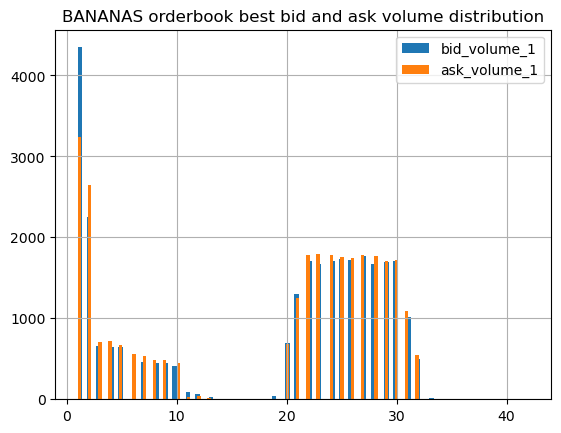

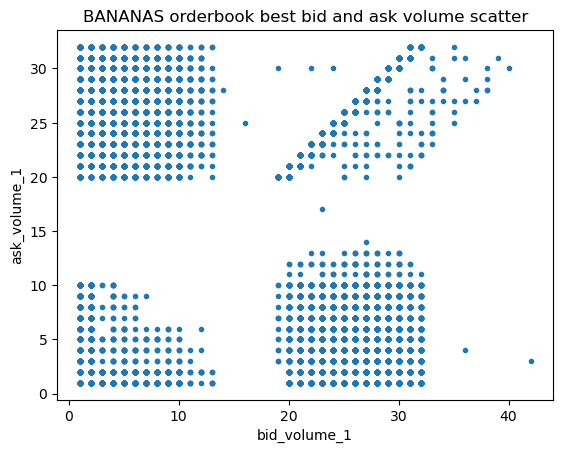

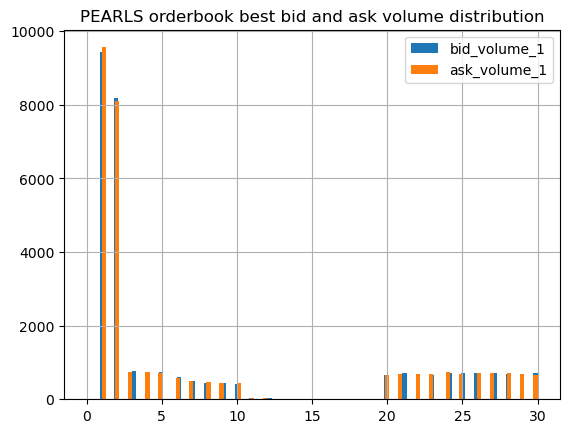

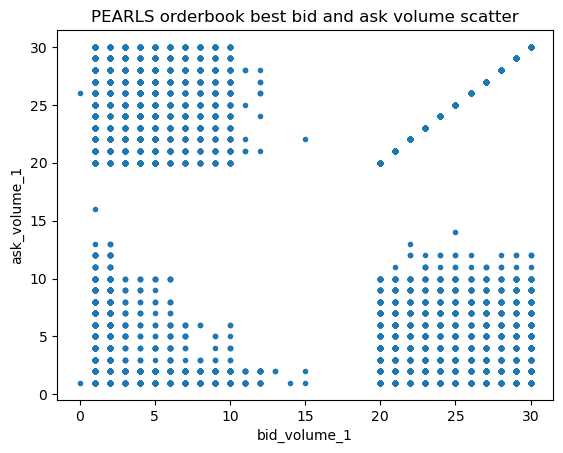

In [5]:
plot_orderbook_dist(r2,ticker = 'BANANAS')
plot_orderbook_dist(r2,ticker = 'PEARLS')

In [6]:
r2_w_move = r2.pipe(calculate_volume_imbalance,level = 1).pipe(calculate_volume_imbalance,level = 2).pipe(calculate_future_mid_price_movement,window_size = 9).pipe(cal_orderbook_imbalance_status)

In [7]:
def plot_volume_imbalance(df, product, level):
    temp = df[df['product'] == product]
    plt.hist(temp['volume_imbalance_'+str(level)],bins=100)
    plt.title(product+' volume_imbalance_'+str(level))
    plt.show()
    return 0

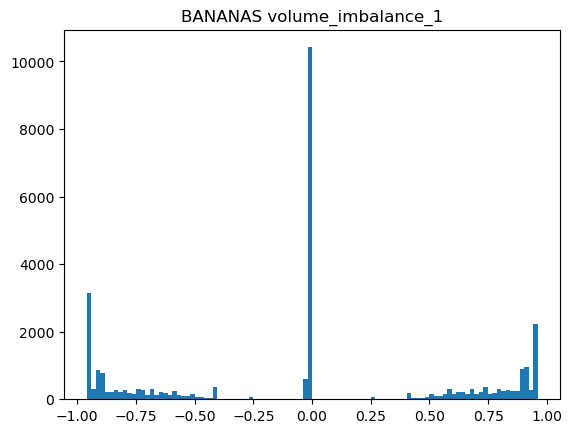

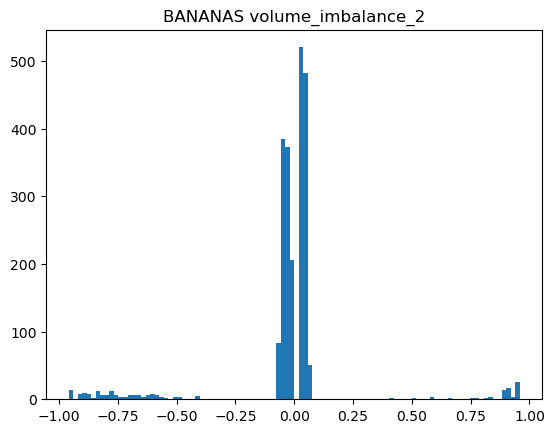

0

In [8]:
r2_w_move.pipe(plot_volume_imbalance, product = 'BANANAS', level = 1)
r2_w_move.pipe(plot_volume_imbalance, product = 'BANANAS', level = 2)


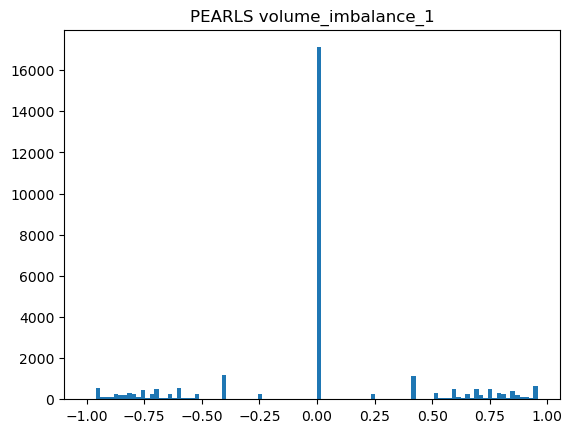

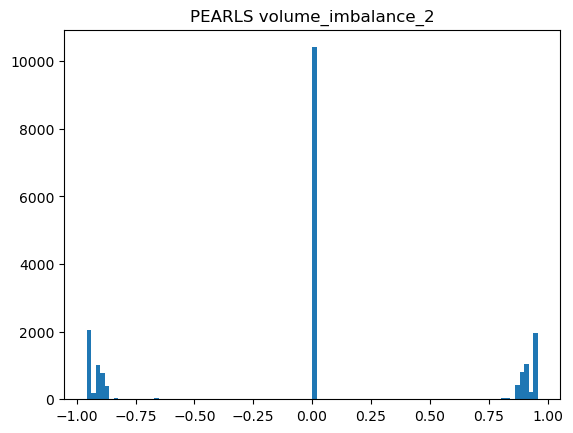

0

In [9]:

r2_w_move.pipe(plot_volume_imbalance, product = 'PEARLS', level = 1)
r2_w_move.pipe(plot_volume_imbalance, product = 'PEARLS', level = 2)

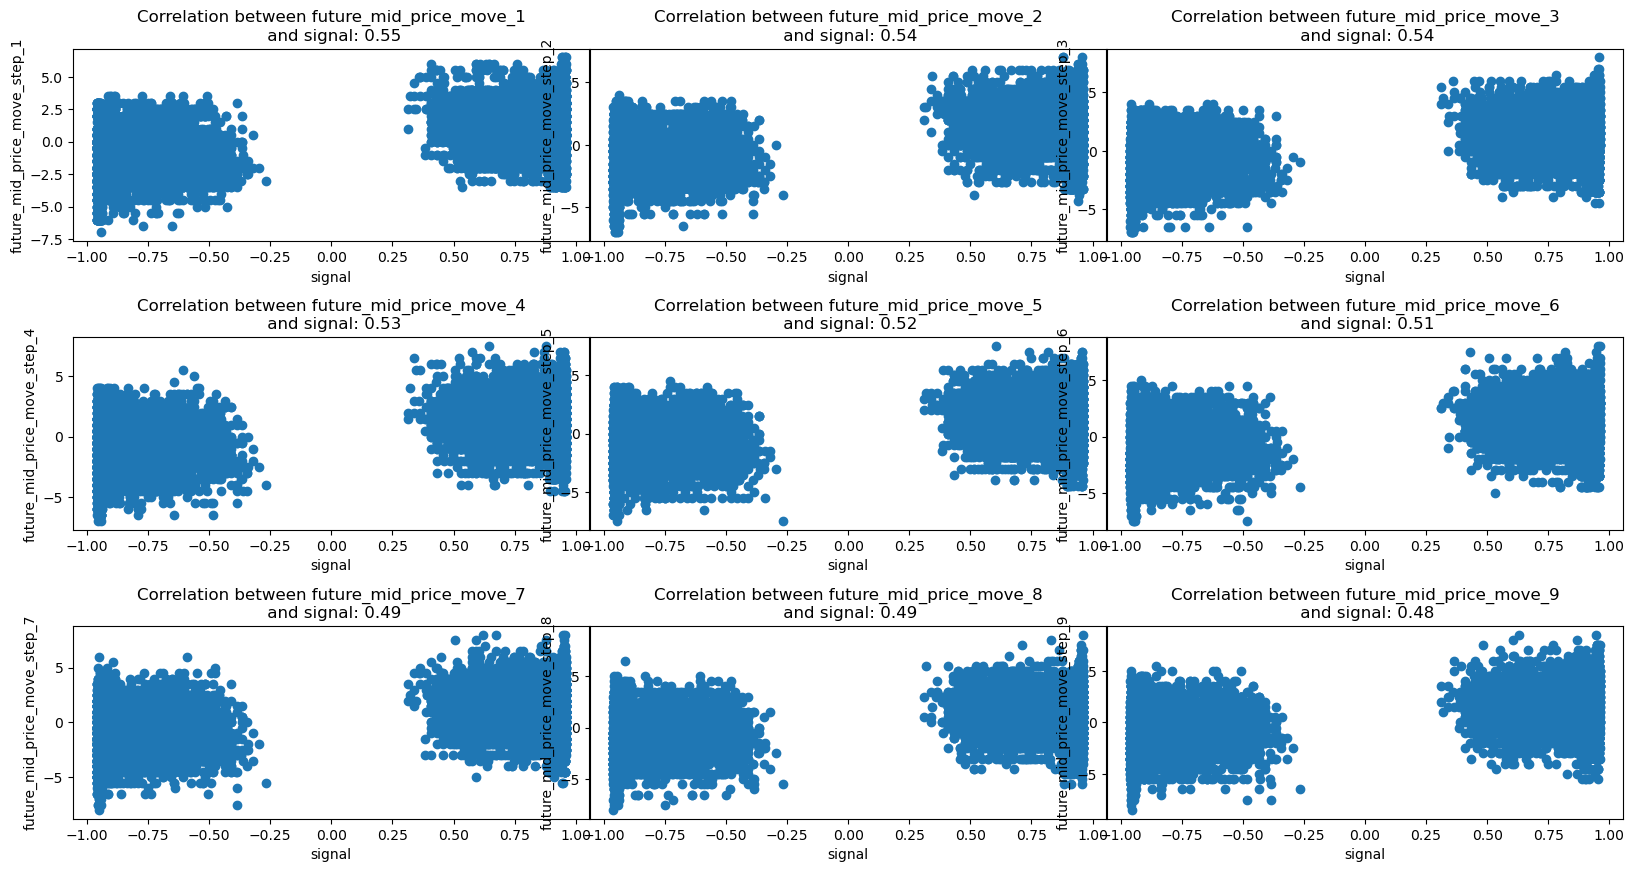

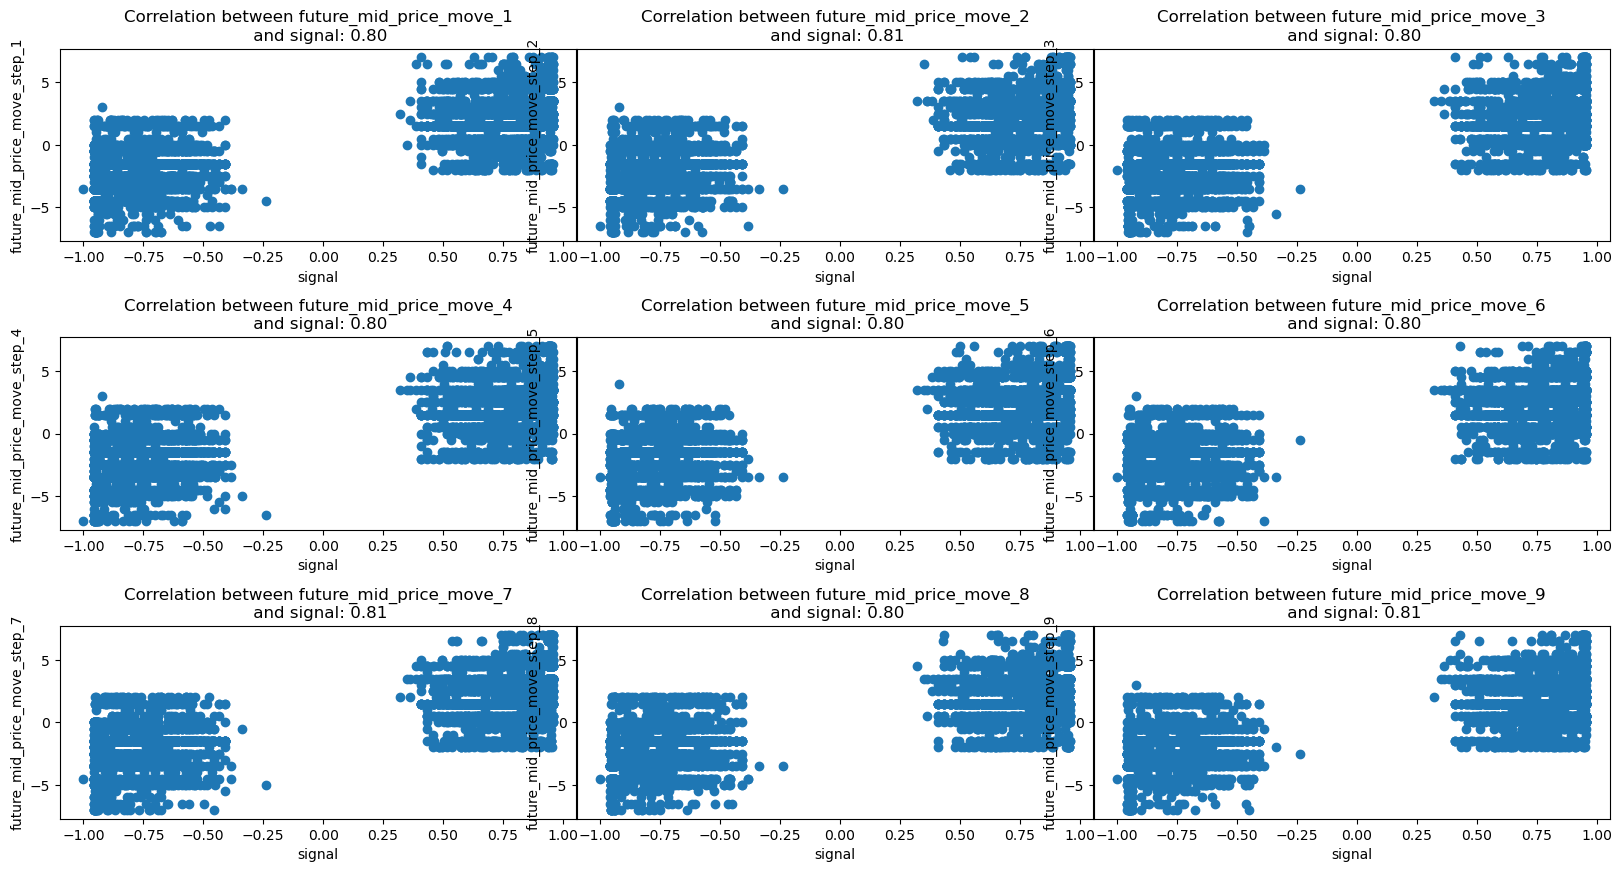

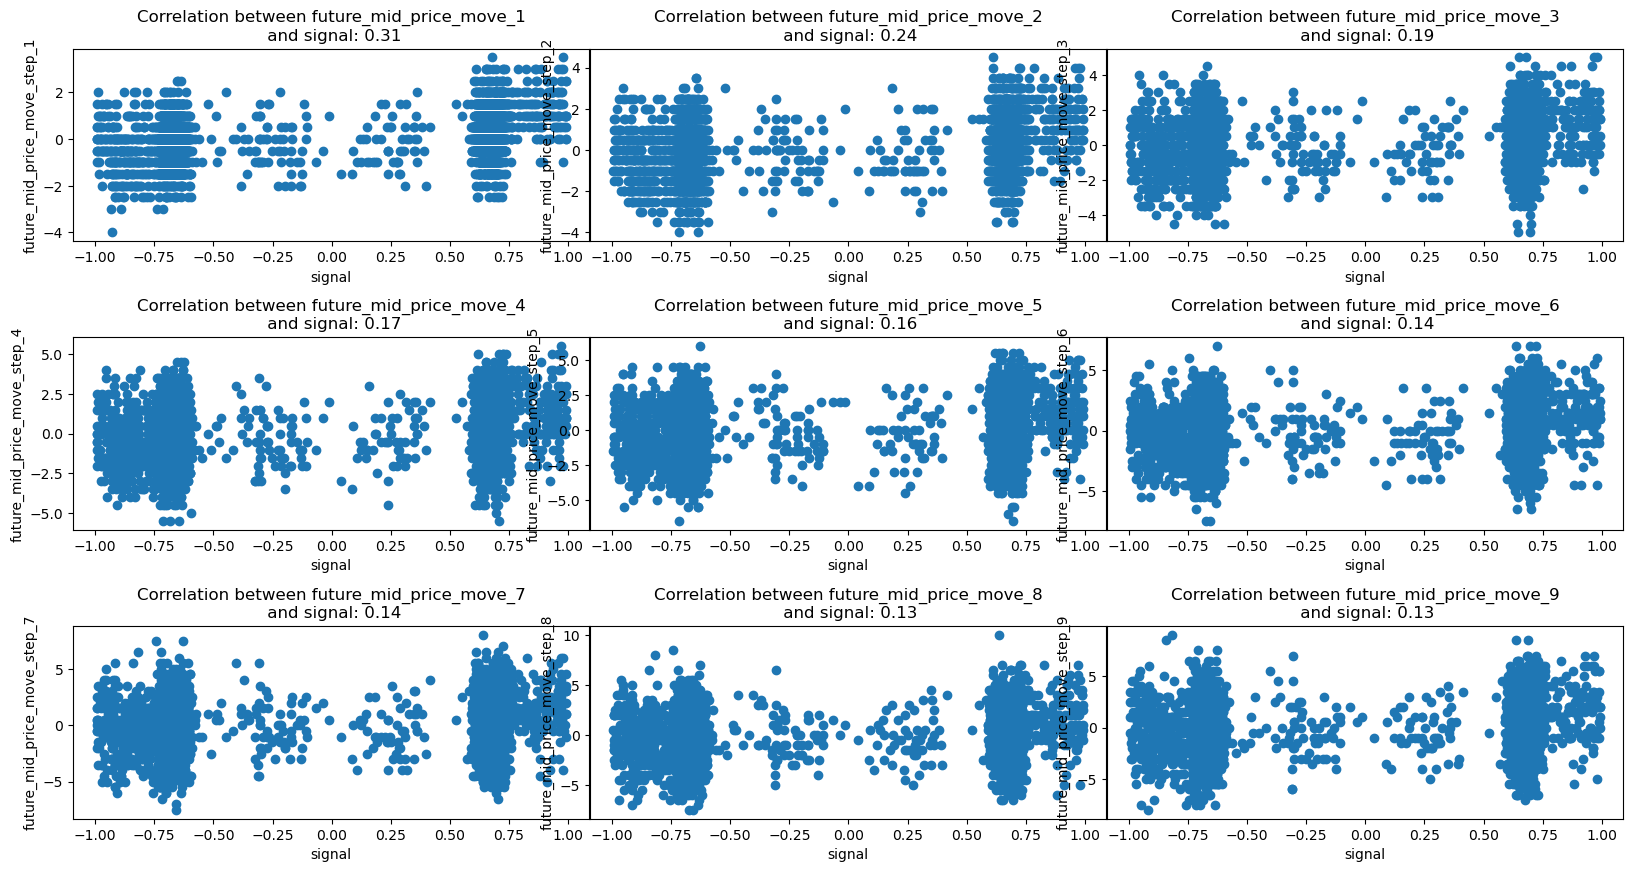

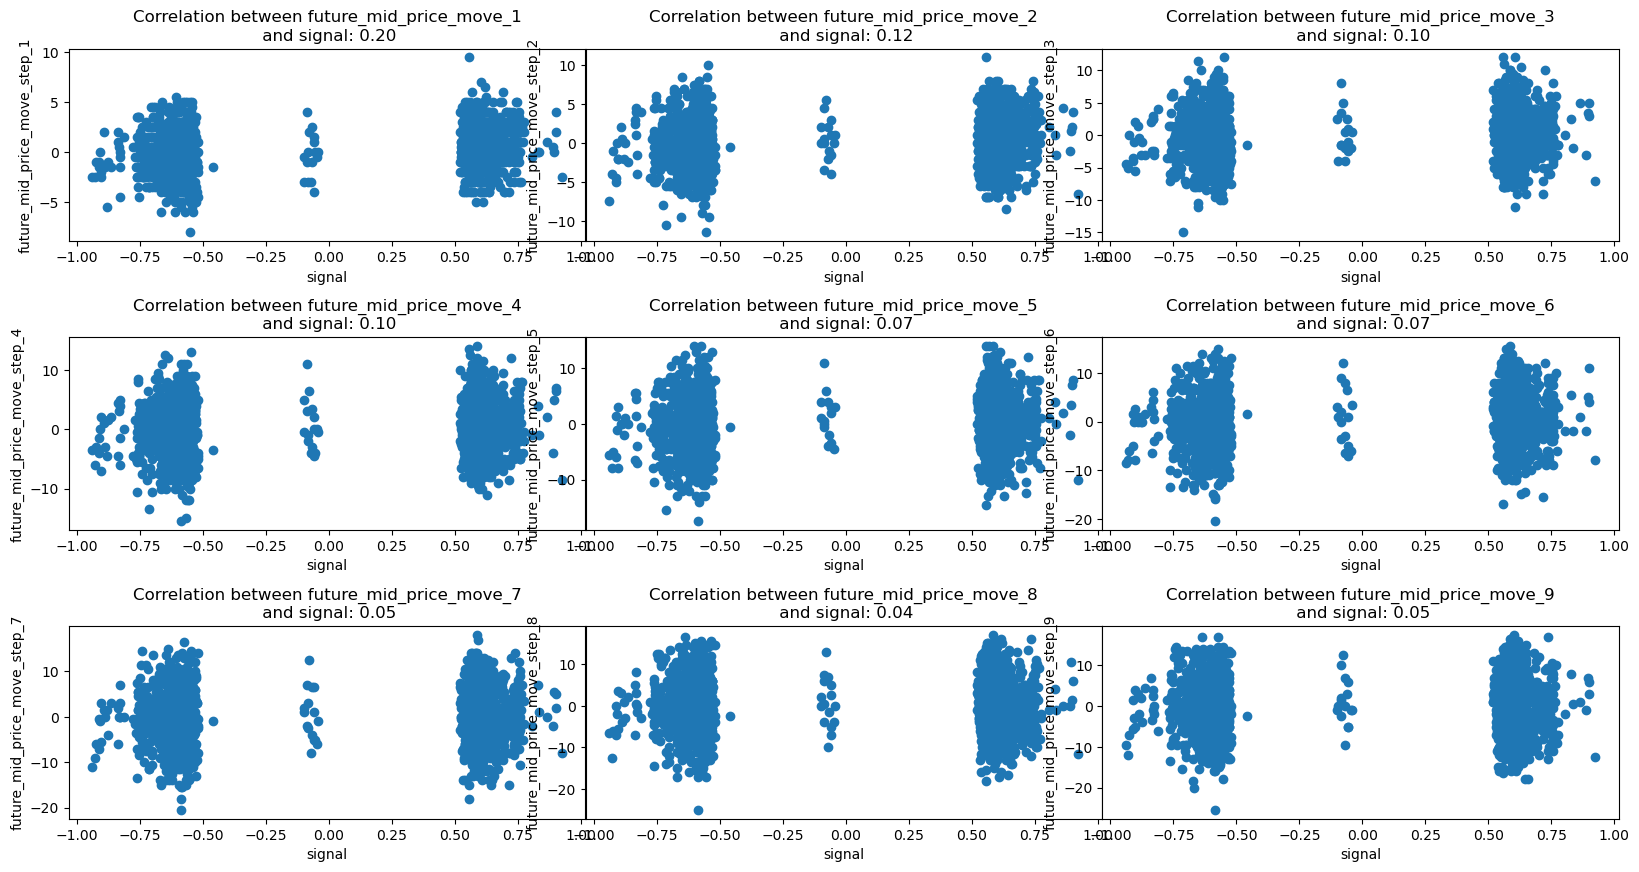

0

In [10]:
r2_w_move[(r2_w_move['imbalance_status']!=10)&(r2_w_move['imbalance_status']!=0)].pipe(plot_em_am, ticker = 'BANANAS', signal = 'volume_imbalance_1')
r2_w_move[(r2_w_move['imbalance_status']!=10)&(r2_w_move['imbalance_status']!=0)].pipe(plot_em_am, ticker = 'PEARLS', signal = 'volume_imbalance_1')
r2_w_move[(r2_w_move['imbalance_status']!=10)&(r2_w_move['imbalance_status']!=0)].pipe(plot_em_am, ticker = 'COCONUTS', signal = 'volume_imbalance_1')
r2_w_move[(r2_w_move['imbalance_status']!=10)&(r2_w_move['imbalance_status']!=0)].pipe(plot_em_am, ticker = 'PINA_COLADAS', signal = 'volume_imbalance_1')

In [11]:
r2_w_move.groupby(['product','imbalance_status'])['future_mid_price_move_1'].mean()

product       imbalance_status
BANANAS       -1                 -0.984807
               0                 -0.120778
               1                  1.057821
               10                -0.000652
COCONUTS      -1                 -0.241671
               0                 -0.293814
               1                  0.322132
               10                -0.007156
PEARLS        -1                 -2.220643
               0                 -0.019003
               1                  2.245333
               10                 0.044479
PINA_COLADAS  -1                 -0.353114
               0                 -0.003915
               1                  0.462321
               10                -0.040200
Name: future_mid_price_move_1, dtype: float64

### conclusion for BANANAs and PEARLS: 

- BANANA fair price = mid_price +1*imbalance
- PEARL fair price = mid_price + 2*imbalance


But similiar strategy produce terrible Pnl for the other 2 products.
- coconut fair price = mid_price + 0.3*imbalance
- pina colada fair price = mid_price + 0.4*imbalance

## EDA for coconut and pina colada on Round 2

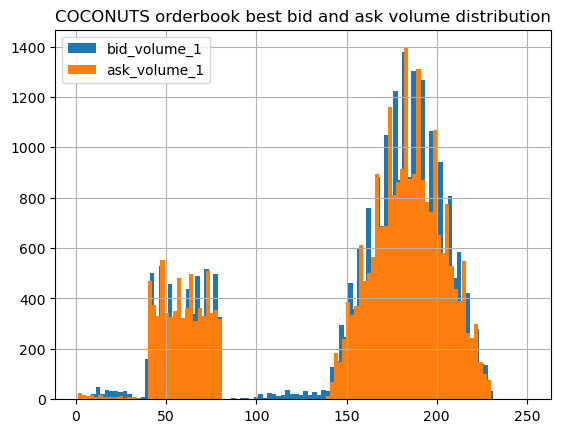

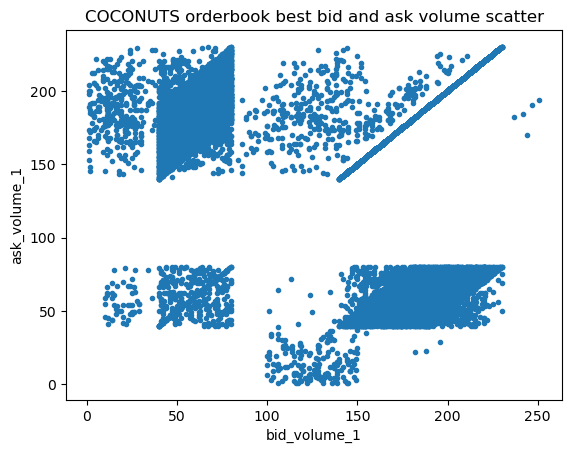

In [12]:
plot_orderbook_dist(r2,ticker = 'COCONUTS')


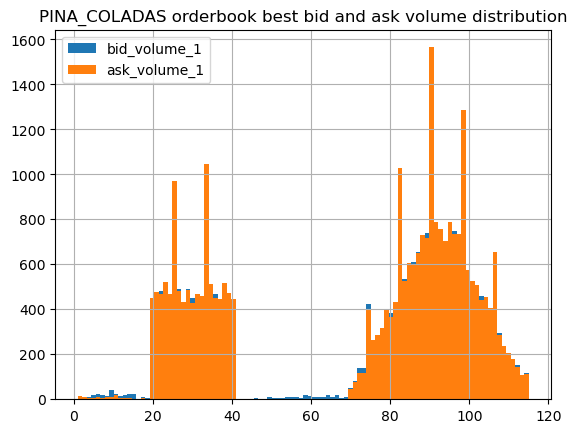

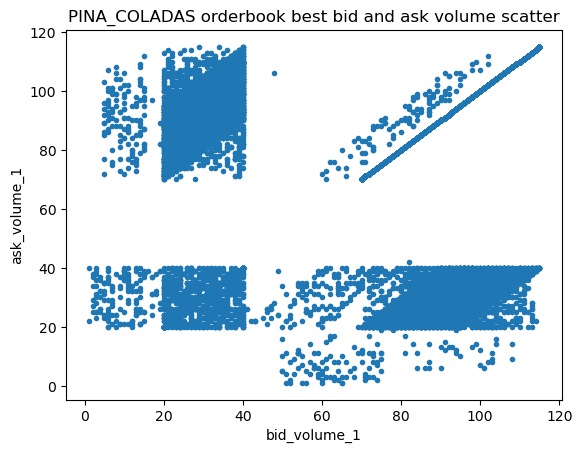

In [13]:
plot_orderbook_dist(r2,ticker = 'PINA_COLADAS')

In [14]:
r2_pairs = r2[(r2['product']=='PINA_COLADAS')|(r2['product']=='COCONUTS')].reset_index(drop=True)

In [15]:

r2_pairs.head(5)

,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,volume_imbalance_1
0,-1000000,PINA_COLADAS,14999,38,14998.0,53.0,NaN,NaN,15001,38,15002.0,53.0,NaN,NaN,15000.0,0.0,0.000000
1,-1000000,COCONUTS,7999,162,NaN,NaN,NaN,NaN,8001,55,8002.0,107.0,NaN,NaN,8000.0,0.0,0.583274
2,-999900,COCONUTS,7998,187,NaN,NaN,NaN,NaN,8001,187,NaN,NaN,NaN,NaN,7999.5,0.0,0.000000
3,-999900,PINA_COLADAS,14999,31,14998.0,64.0,NaN,NaN,15001,31,15002.0,64.0,NaN,NaN,15000.0,0.0,0.000000
4,-999800,COCONUTS,7997,191,NaN,NaN,NaN,NaN,8000,191,NaN,NaN,NaN,NaN,7998.5,0.0,0.000000


In [16]:
pina_mid = r2_pairs[r2_pairs['product']=='PINA_COLADAS']['mid_price'].reset_index(drop=True)
coconuts_mid = r2_pairs[r2_pairs['product']=='COCONUTS']['mid_price'].reset_index(drop=True)


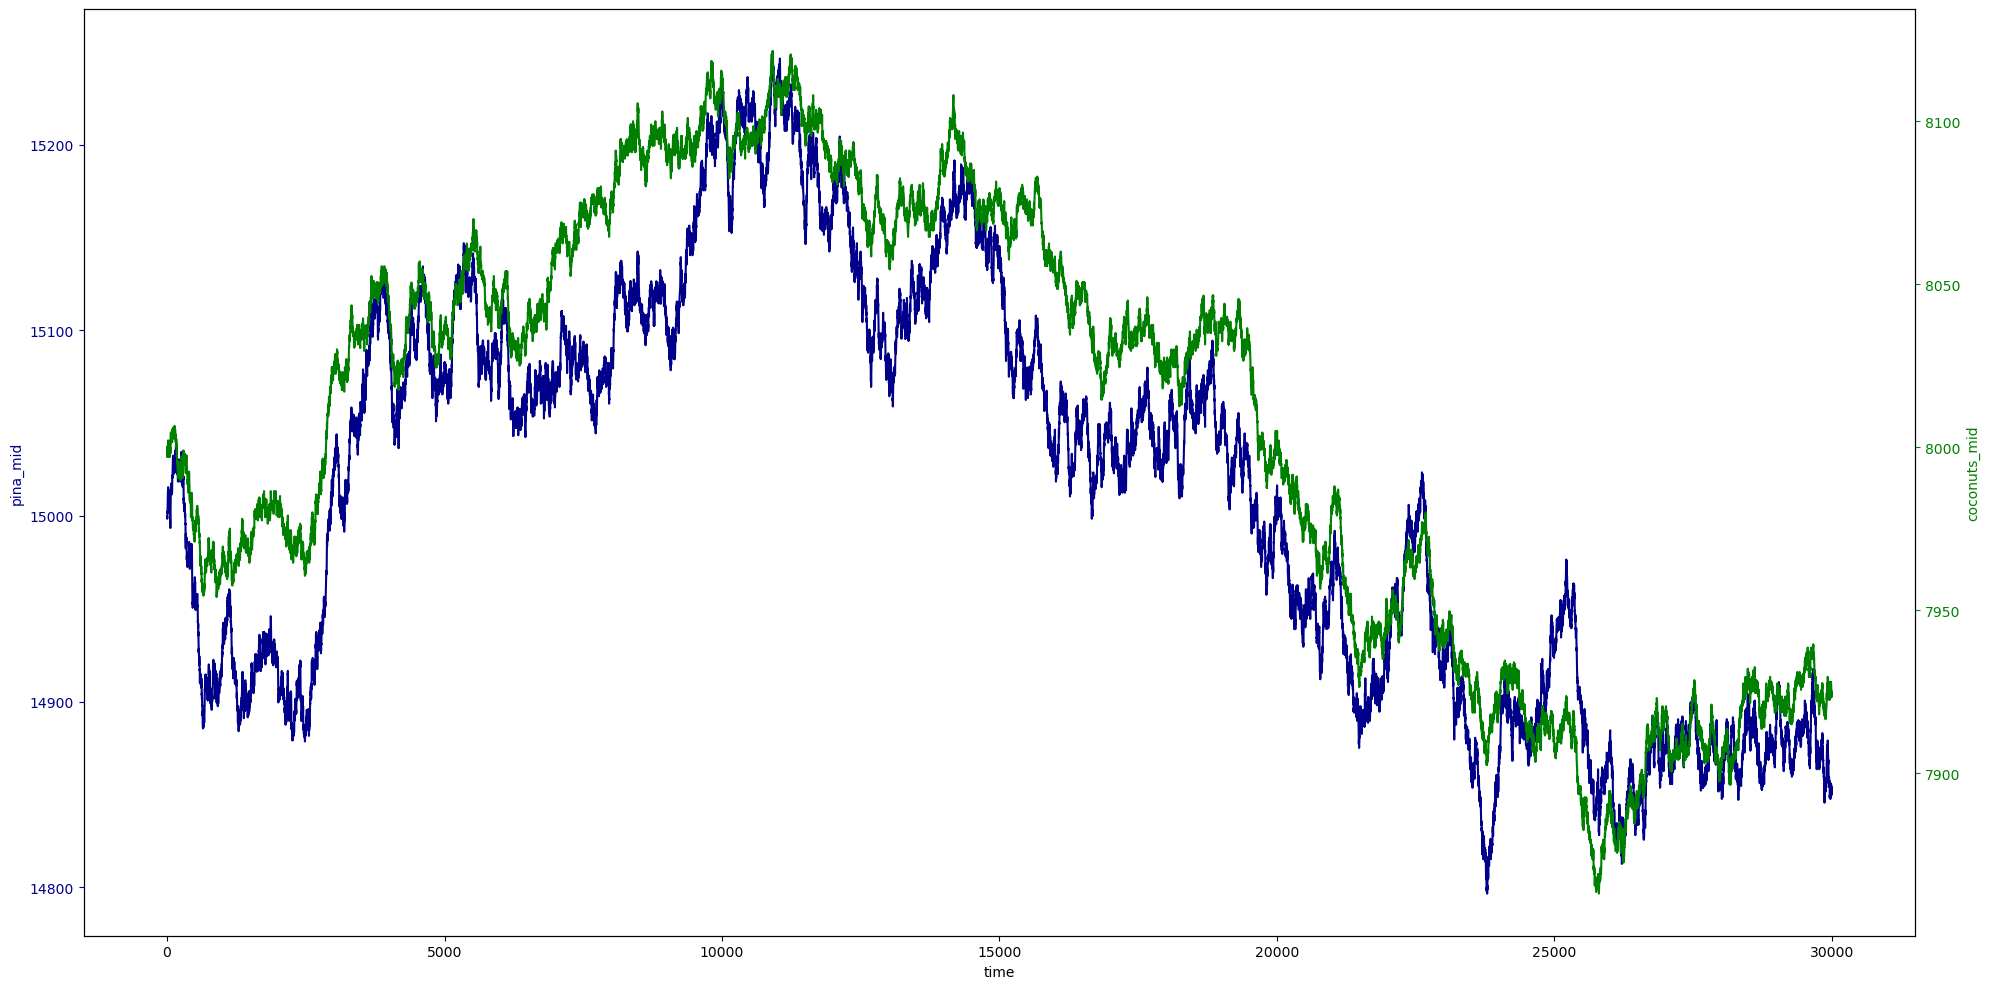

In [17]:
# plot pina_mid and coconuts_mid in one plot with 2 y axes
fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.plot(pina_mid, 'darkblue')
ax1.set_xlabel('time')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('pina_mid', color='darkblue')
ax1.tick_params('y', colors='darkblue')
ax2 = ax1.twinx()
ax2.plot(coconuts_mid, 'g-')
ax2.set_ylabel('coconuts_mid', color='g')
ax2.tick_params('y', colors='g')

fig.tight_layout()
plt.show()

In [18]:
# do a regression on 2 series
import statsmodels.api as sm
X = sm.add_constant(coconuts_mid)
model = sm.OLS(pina_mid, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              mid_price   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                 3.565e+05
Date:                Tue, 28 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:21:50   Log-Likelihood:            -1.4513e+05
No. Observations:               30000   AIC:                         2.903e+05
Df Residuals:                   29998   BIC:                         2.903e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2593.3223     20.806    124.642      0.0

### guess the linear relationship between pina colada and coconut

#### Trial 1: pina = 2*coconut -1000

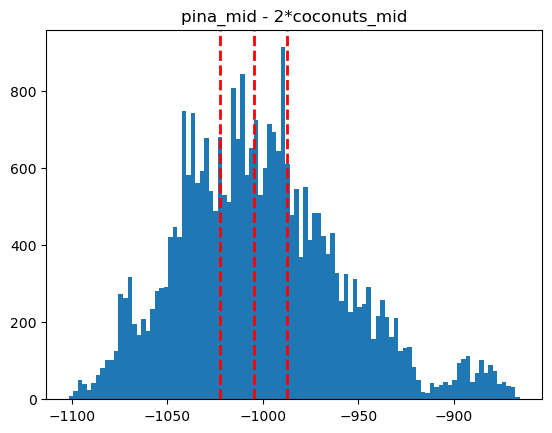

10.0
11.0


In [22]:
plt.title('pina_mid - 2*coconuts_mid')
plt.hist(pina_mid-2*coconuts_mid,bins = 100)
# plot a vertical line at the median 
plt.axvline((pina_mid-2*coconuts_mid).median(), color='r', linestyle='dashed', linewidth=2)

# plot 40 and 60% quantile
plt.axvline((pina_mid-2*coconuts_mid).quantile(0.33), color='r', linestyle='dashed', linewidth=2)
plt.axvline((pina_mid-2*coconuts_mid).quantile(0.66), color='r', linestyle='dashed', linewidth=2)

plt.show()

dist1 = (pina_mid-2*coconuts_mid).median()-(pina_mid-2*coconuts_mid).quantile(0.4)
dist2 = (pina_mid-2*coconuts_mid).quantile(0.6)-(pina_mid-2*coconuts_mid).median()
print(dist1)
print(dist2)

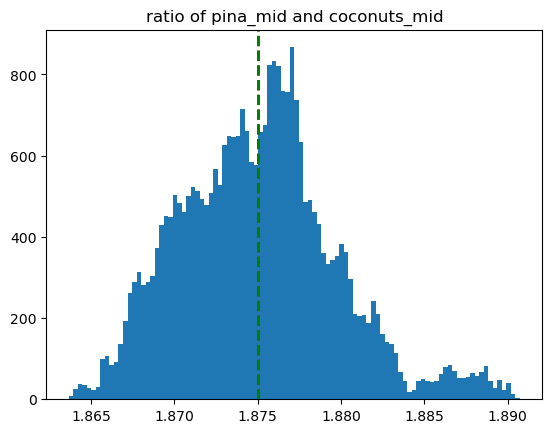

In [55]:
# plot the ratio of pina_mid and coconuts_mid
plt.title('ratio of pina_mid and coconuts_mid')
plt.hist(pina_mid/coconuts_mid,bins = 100)
# plot a vertical line at the median 
plt.axvline((pina_mid/coconuts_mid).median(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(15/8, color='g', linestyle='dashed', linewidth=2)

### findings
- we can see that the orderbook volume of the coconut is roughly double that of the pina colada
- we know from the position limit that coconut is also doubled that of pina colada
- we know from the mid price of coconut is roughly half that of pina colada

so we can guess that the pair that we wanna trade is something like this:
$$
ETF = 2*coconut - pina colada+coef
$$

In [18]:
ETF_mid = coconuts_mid*2-pina_mid

median of the series: 1004.50
mean of the series: 1000.94


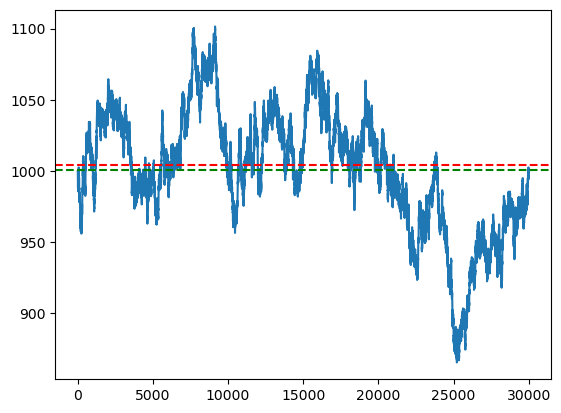

In [19]:
plt.plot(ETF_mid)
# plot a horizontal line at the median of the series
plt.axhline(ETF_mid.median(), color='r', linestyle='--')
print('median of the series: %.2f'%ETF_mid.median())
plt.axhline(ETF_mid.mean(), color='g', linestyle='--')
print('mean of the series: %.2f'%ETF_mid.mean())
plt.show()

From the material provided by IMC, we know the fair price of coconut is 8000 and pina colada is 15000. So we can guess that the parity is something like this:

$$
pina colada = 2*coconut -1000
$$

## idea 1
idea for coconut and pina colada:
- let's produce a fake orderbook for the parity relationship
- the ETF is 2*coconut - pina colada, it should have a fair price of 1000
- then we use the same strategy as before.



In [52]:
r2_pairs.head(5)

,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,volume_imbalance_1
0,-1000000,PINA_COLADAS,14999,38,14998.0,53.0,NaN,NaN,15001,38,15002.0,53.0,NaN,NaN,15000.0,0.0,0.000000
1,-1000000,COCONUTS,7999,162,NaN,NaN,NaN,NaN,8001,55,8002.0,107.0,NaN,NaN,8000.0,0.0,0.583274
2,-999900,COCONUTS,7998,187,NaN,NaN,NaN,NaN,8001,187,NaN,NaN,NaN,NaN,7999.5,0.0,0.000000
3,-999900,PINA_COLADAS,14999,31,14998.0,64.0,NaN,NaN,15001,31,15002.0,64.0,NaN,NaN,15000.0,0.0,0.000000
4,-999800,COCONUTS,7997,191,NaN,NaN,NaN,NaN,8000,191,NaN,NaN,NaN,NaN,7998.5,0.0,0.000000


### parity relation

$$
ETF = 2*coconut - pina colada
$$

- fair price = 1000
- mid price = 2*coco_mid_price - pina_mid_price
- best bid = 2*coconut*best_bid-1* pina_colada*best_ask
- best ask = 2*coconut*best_ask-1* pina_colada*best_bid
- best bid volume = 2*coconut*best_bid_volume-1* pina_colada*best_ask_volume
- best ask volume = 2*coconut*best_ask_volume-1* pina_colada*best_bid_volume


In [53]:
virtual_etf = pd.read_csv('virtual_etf.csv')

In [54]:
virtual_etf.rename(columns={'Unnamed: 0':'time','best_bid':'best_bid_1','best_bid_volume':'bid_volume_1','best_ask':'best_ask_1','best_ask_volume':'ask_volume_1'},inplace=True)

In [55]:
virtual_etf['product']= 'VIRTUAL_ETF'

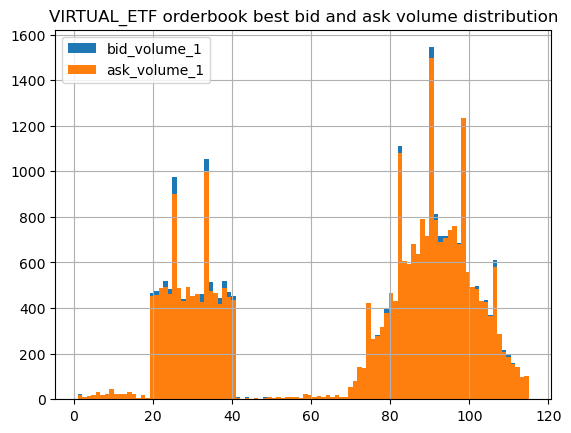

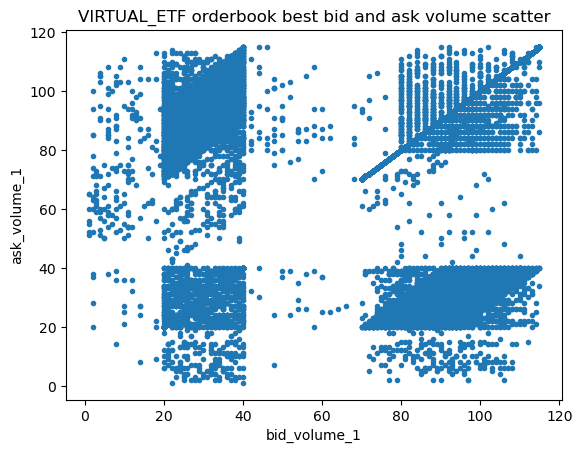

In [56]:
virtual_etf.pipe(plot_orderbook_dist,ticker = 'VIRTUAL_ETF')

In [57]:
virtual_etf_w_move = virtual_etf.pipe(cal_orderbook_imbalance_status).pipe(calculate_volume_imbalance).pipe(calculate_future_mid_price_movement,window_size = 9)


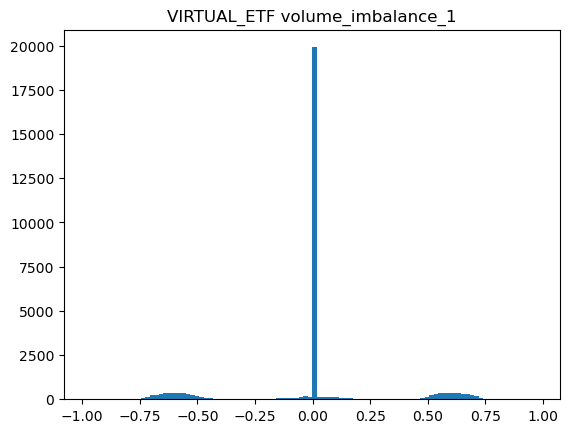

0

In [58]:
virtual_etf_w_move.pipe(plot_volume_imbalance, product = 'VIRTUAL_ETF', level = 1)

In [61]:
virtual_etf_w_move.groupby(['imbalance_status'])['future_mid_price_move_1'].mean()

imbalance_status
-1    -0.519449
 0     0.016777
 1     0.476474
 10    0.009987
Name: future_mid_price_move_1, dtype: float64

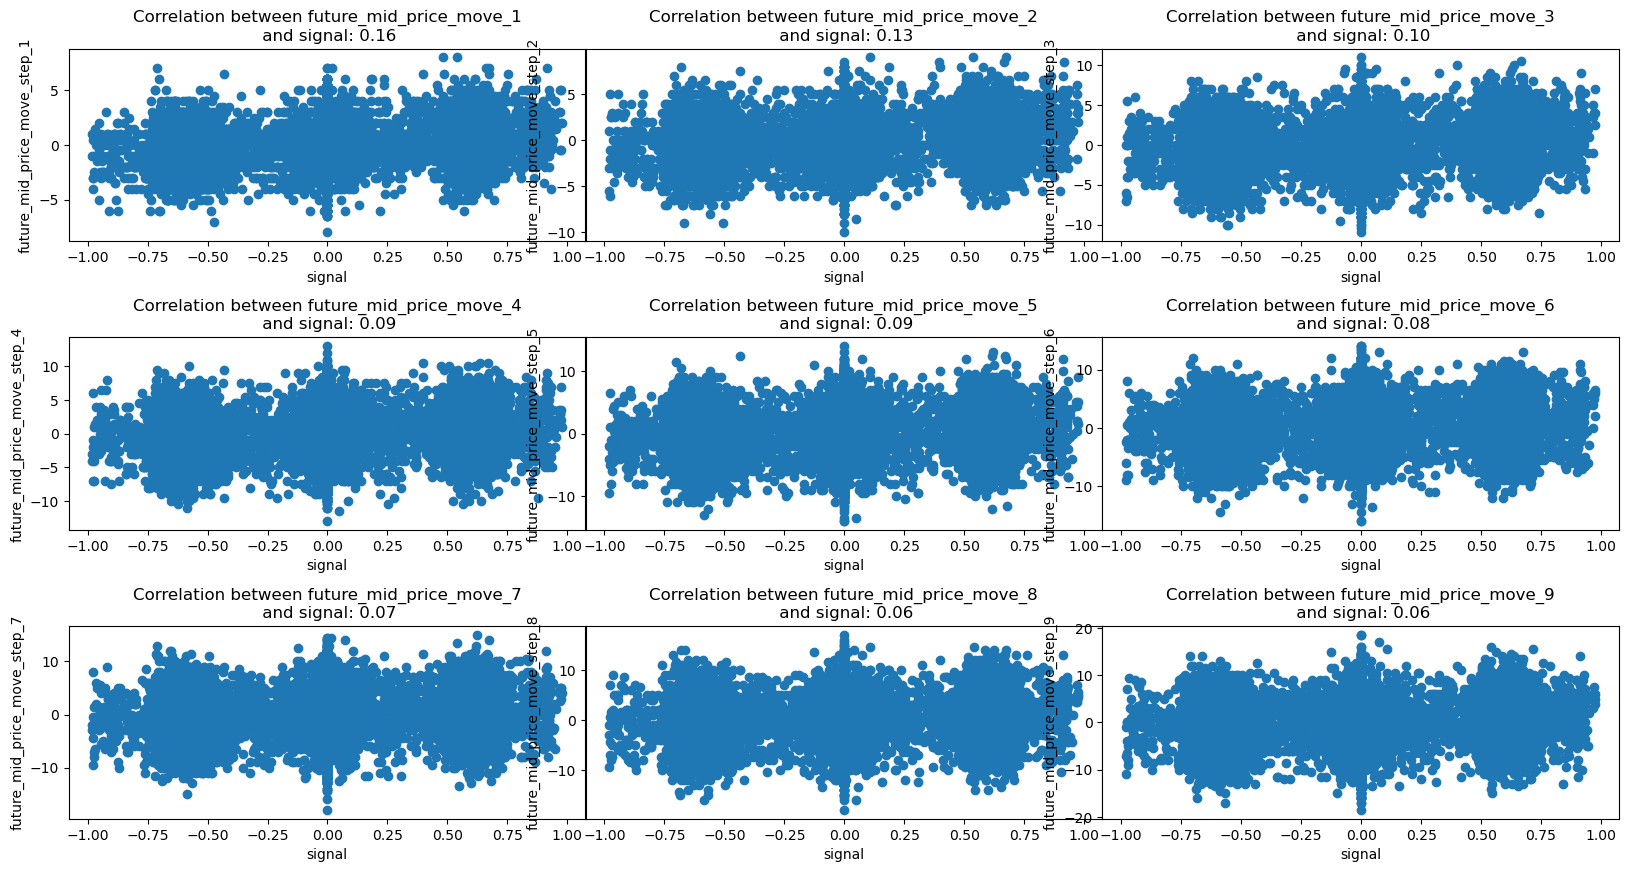

0

In [63]:
virtual_etf_w_move[(virtual_etf_w_move['imbalance_status']!=0)|virtual_etf_w_move['imbalance_status']!=10].pipe(plot_em_am, ticker = 'VIRTUAL_ETF', signal = 'volume_imbalance_1')

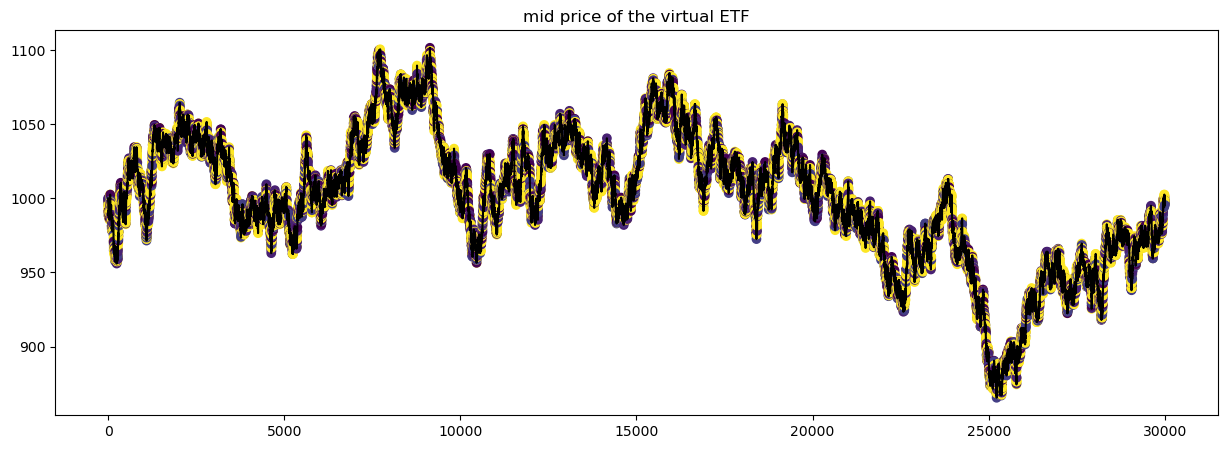

In [68]:

# plot the mid price of the virtual ETF
# color mid price based on the imbalance status column
plt.figure(figsize=(15,5))
plt.plot(virtual_etf_w_move['mid_price'],color='k')
plt.scatter(virtual_etf_w_move.index,virtual_etf_w_move['mid_price'],c=virtual_etf_w_move['imbalance_status'])
plt.title('mid price of the virtual ETF')
plt.show()
